In [1]:
import pandas as pd
import os
import sys  
sys.path.insert(0, './MAIN/')
import MOGDx
import Network
import AE
import GNN
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import warnings
from tensorflow import keras
import stellargraph as sg
warnings.filterwarnings("ignore")

Finished Library Import 



In [2]:
graph_file = './raw/V02/V02_mRNA_MDS-UPDRS_graph.csv'

datModalities , meta = MOGDx.data_parsing('raw/V02' ,graph_file , 'CONCOHORT_DEFINITION' , 'PATNO')

G = Network.network_from_csv(graph_file , False)

node_subjects = meta.loc[pd.Series(nx.get_node_attributes(G , 'idx'))].reset_index(drop=True)
node_subjects.name = 'CONCOHORT_DEFINITION'

Importing 	 raw/V02/datExpr_mRNA.csv 

Importing 	 raw/V02/datExpr_MDS-UPDRS.csv 



In [3]:
# Specify the path to the saved model
ae_model_path = 'Output/PPMI/V02/AE_models/'

reduced_df = pd.DataFrame()
for modality in graph_file.split('_')[1:-1] : 
    
    # Load the saved model
    AE_modality = torch.load(ae_model_path + 'AE_model_' + modality)

    # Create a new instance of your model
    AE_model = AE.AE(latent_dim=AE_modality['model_state_dict']['encoder.0.weight'].shape[0] , inputs=AE_modality['model_state_dict']['encoder.0.weight'].shape[1])  # Replace with your model definition

    # Load the model's state dictionary
    AE_model.load_state_dict(AE_modality['model_state_dict'])

    # Load the optimizer's state dictionary (optional)
    optimizer = torch.optim.Adam(AE_model.parameters(),
                            lr = 0.01,
                            weight_decay = 1e-8)  # Replace with your optimizer
    optimizer.load_state_dict(AE_modality['optimizer_state_dict'])

    # Load any other saved information (e.g., loss function)
    loss_fn = AE_modality['loss_fn']

    # Put the model in evaluation mode (e.g., for inference)
    #AE_model.eval()

    df = pd.read_csv(f'raw/V02/datExpr_{modality}.csv' , index_col=0)
    meta = pd.read_csv(f'raw/V02/datMeta_{modality}.csv' , index_col=0)

    if len(set(meta.index.astype(str)) & set(df.columns)) > 0 :
        df = df.T
        df.index = df.index.astype(str)
    else :
        df.index = df.index.astype(str)
        pass

    df_scaled = AE.scale_datasets(df, mean = [] , std = [])['x_1'] #scale data
    
    # Get the reduced version of the data from the AE
    reduced_df_tmp = pd.DataFrame(AE_model.forward(torch.tensor(df_scaled.to_numpy() , dtype=torch.float , device='cpu'))[0].detach().numpy() , index=df.index)
    reduced_df_tmp = reduced_df_tmp.add_prefix(f'data_{modality}_feature_')
    reduced_df = pd.concat([reduced_df , reduced_df_tmp] , axis=1)
    reduced_df = reduced_df.fillna(reduced_df.median())

In [42]:
node_ft_mtx = pd.read_csv('Output/PPMI/V02/node_feature_mtx.csv' , index_col=0)

In [43]:
reduced_df

,data_mRNA_feature_0,data_mRNA_feature_1,data_mRNA_feature_2,data_mRNA_feature_3,data_mRNA_feature_4,data_mRNA_feature_5,data_mRNA_feature_6,data_mRNA_feature_7,data_mRNA_feature_8,data_mRNA_feature_9,...,data_mRNA_feature_30,data_mRNA_feature_31,data_MDS-UPDRS_feature_0,data_MDS-UPDRS_feature_1,data_MDS-UPDRS_feature_2,data_MDS-UPDRS_feature_3,data_MDS-UPDRS_feature_4,data_MDS-UPDRS_feature_5,data_MDS-UPDRS_feature_6,data_MDS-UPDRS_feature_7
3000,0.289908,0.147210,0.724276,0.738124,0.141901,0.956883,0.344340,0.523202,0.314046,0.077504,...,0.082495,0.521408,0.655197,0.553974,0.562611,0.464565,0.655249,0.342194,0.247998,0.438846
3004,0.651069,0.554053,0.690543,0.729684,0.342064,0.750220,0.312212,0.593413,0.296949,0.141257,...,0.490993,0.389527,0.655197,0.553974,0.562611,0.464565,0.655249,0.342194,0.247998,0.438846
3008,0.379788,0.934561,0.940689,0.942710,0.482776,0.962151,0.140817,0.257066,0.066592,0.632906,...,0.851028,0.048946,0.655197,0.553974,0.562611,0.464565,0.655249,0.342194,0.247998,0.438846
3009,0.577771,0.924028,0.818578,0.789206,0.799562,0.728202,0.468908,0.551984,0.206497,0.861438,...,0.799004,0.127772,0.655197,0.553974,0.562611,0.464565,0.655249,0.342194,0.247998,0.438846
3011,0.145508,0.657428,0.880017,0.936612,0.145748,0.905786,0.571129,0.131074,0.080198,0.215473,...,0.355911,0.073630,0.655197,0.553974,0.562611,0.464565,0.655249,0.342194,0.247998,0.438846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163265,0.476761,0.389534,0.655939,0.615314,0.492604,0.601089,0.461272,0.520560,0.405819,0.420734,...,0.382523,0.400031,0.980618,0.733396,0.211420,0.700906,0.863144,0.938885,0.624028,0.183800
167580,0.476761,0.389534,0.655939,0.615314,0.492604,0.601089,0.461272,0.520560,0.405819,0.420734,...,0.382523,0.400031,0.881135,0.132241,0.868433,0.627110,0.038420,0.403718,0.443865,0.758065
167657,0.476761,0.389534,0.655939,0.615314,0.492604,0.601089,0.461272,0.520560,0.405819,0.420734,...,0.382523,0.400031,0.472092,0.611696,0.409008,0.500098,0.743950,0.452129,0.055581,0.783016
174615,0.476761,0.389534,0.655939,0.615314,0.492604,0.601089,0.461272,0.520560,0.405819,0.420734,...,0.382523,0.400031,0.744262,0.639320,0.204794,0.955276,0.374273,0.412255,0.546389,0.280546


In [44]:
node_ft_mtx.loc[reduced_df.index.astype(int)]

,data_mRNA_feature_0,data_mRNA_feature_1,data_mRNA_feature_2,data_mRNA_feature_3,data_mRNA_feature_4,data_mRNA_feature_5,data_mRNA_feature_6,data_mRNA_feature_7,data_mRNA_feature_8,data_mRNA_feature_9,...,data_mRNA_feature_30,data_mRNA_feature_31,data_MDS-UPDRS_feature_0,data_MDS-UPDRS_feature_1,data_MDS-UPDRS_feature_2,data_MDS-UPDRS_feature_3,data_MDS-UPDRS_feature_4,data_MDS-UPDRS_feature_5,data_MDS-UPDRS_feature_6,data_MDS-UPDRS_feature_7
3000,0.274614,0.146193,0.732487,0.738663,0.156632,0.953643,0.350924,0.505885,0.311700,0.077919,...,0.083495,0.519479,0.661961,0.556160,0.561557,0.465794,0.661498,0.342434,0.236570,0.437017
3004,0.630011,0.539783,0.699832,0.728695,0.359018,0.742801,0.319516,0.579012,0.296030,0.142725,...,0.498760,0.388166,0.661961,0.556160,0.561557,0.465794,0.661498,0.342434,0.236570,0.437017
3008,0.365300,0.927370,0.944441,0.941835,0.501318,0.959936,0.152707,0.263139,0.067953,0.631055,...,0.854301,0.048130,0.661961,0.556160,0.561557,0.465794,0.661498,0.342434,0.236570,0.437017
3009,0.557657,0.913711,0.831825,0.793585,0.801816,0.726257,0.464898,0.542674,0.202107,0.853701,...,0.803162,0.123664,0.661961,0.556160,0.561557,0.465794,0.661498,0.342434,0.236570,0.437017
3011,0.155967,0.665145,0.885322,0.934021,0.112103,0.905323,0.598786,0.108514,0.081226,0.250798,...,0.348416,0.072055,0.670505,0.597883,0.553585,0.432873,0.639453,0.369090,0.236463,0.409496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163265,0.478058,0.387381,0.641586,0.616753,0.489197,0.596826,0.452910,0.512032,0.403474,0.413516,...,0.383139,0.407082,0.981476,0.733163,0.213903,0.710093,0.869056,0.930753,0.621016,0.177939
167580,0.478058,0.387381,0.641586,0.616753,0.489197,0.596826,0.452910,0.512032,0.403474,0.413516,...,0.383139,0.407082,0.880263,0.132962,0.869985,0.637568,0.042093,0.384270,0.459926,0.754611
167657,0.478058,0.387381,0.641586,0.616753,0.489197,0.596826,0.452910,0.512032,0.403474,0.413516,...,0.383139,0.407082,0.475056,0.611575,0.405470,0.508274,0.748006,0.443132,0.055926,0.778448
174615,0.467948,0.358236,0.652302,0.673506,0.459955,0.639689,0.433810,0.543304,0.343075,0.444952,...,0.412312,0.360676,0.656886,0.767173,0.108383,0.966928,0.260716,0.459178,0.548232,0.386331


In [45]:
pd.DataFrame(np.array(reduced_df) - np.array(node_ft_mtx.loc[reduced_df.index.astype(int)])).describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,...,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,-0.001305,-0.002420,0.002919,-0.001850,0.001815,0.001297,0.001157,-0.000675,0.001839,-0.002444,...,-0.000690,0.001162,-0.000855,-0.005421,0.001701,0.004965,0.000896,-0.002143,-0.000502,0.003198
std,0.022376,0.027225,0.021105,0.017924,0.018242,0.017366,0.022474,0.032608,0.021022,0.022392,...,0.011496,0.013371,0.065311,0.054643,0.061613,0.059302,0.059460,0.051647,0.060621,0.050050
min,-0.108664,-0.161690,-0.044292,-0.058192,-0.028014,-0.077444,-0.111107,-0.171159,-0.126825,-0.089530,...,-0.029789,-0.091495,-0.172026,-0.370205,-0.178524,-0.216655,-0.142288,-0.431362,-0.458420,-0.403108
25%,-0.004934,-0.000959,-0.011244,-0.003973,-0.011057,-0.001314,-0.008449,-0.004484,-0.001584,-0.013863,...,-0.005589,-0.007051,-0.007567,-0.004164,-0.005482,-0.009756,-0.009395,-0.002060,-0.009383,0.001166
50%,-0.001296,0.002154,-0.004334,-0.001440,0.000677,0.004263,0.008362,0.008528,0.002346,0.005756,...,-0.000616,0.000868,-0.003565,-0.001114,0.000813,-0.003249,-0.004940,0.000161,-0.002031,0.003427
75%,0.015304,0.012623,0.014353,0.001200,0.003407,0.005629,0.010728,0.014979,0.006457,0.007219,...,-0.000349,0.004823,0.000822,0.003592,0.003123,-0.000718,-0.000006,0.014279,0.011428,0.010431
max,0.029627,0.047265,0.128710,0.109661,0.082762,0.068923,0.080967,0.072390,0.062744,0.076548,...,0.049130,0.039355,0.459814,0.182751,0.771687,0.407506,0.455252,0.110475,0.253142,0.135345


In [46]:
node_features = reduced_df
#node_features = pd.read_csv('Output/PPMI/V02/node_feature_mtx.csv' , index_col=0)
nx.set_node_attributes(G , pd.Series(node_features.values.tolist() , index= [i[0] for i in G.nodes(data=True)]) , 'node_features')

graph = sg.StellarGraph.from_networkx(G , node_features='node_features')

# Specify Stellargraph Generator
generator = sg.mapper.FullBatchNodeGenerator(graph, method="gcn")
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)

model = keras.models.load_model('Output/PPMI/V02/best_model/')

Using GCN (local pooling) filters...


In [47]:
import tensorflow as tf
import numpy as np

all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
emb = embedding_model.predict(all_gen)
print(emb.shape)

X = emb.squeeze(0)

1/1 [==============================] - 0s 67ms/step
(1, 760, 64)


In [48]:
X_tst = pd.read_csv('Output/PPMI/V02/GNN_embeddings.csv' , index_col=0)

In [49]:
pd.DataFrame((np.array(X_tst) - X)).describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,...,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,0.001902,-0.000721,0.000037,0.053286,0.179642,0.000665,0.004778,0.218635,0.004841,0.037242,...,0.102258,0.003097,-0.000251,0.153332,-0.001668,0.030965,-0.000483,0.016281,0.075094,-0.000687
std,0.258601,0.037371,0.311362,0.335239,0.565791,0.376941,0.042327,0.905971,0.087448,0.299822,...,0.537565,0.100649,0.042786,0.783203,0.171736,0.191670,0.172978,0.162158,0.447882,0.443319
min,-0.602648,-0.083054,-0.767344,-0.585626,-0.743119,-0.929223,-0.089499,-0.854792,-0.208127,-0.722936,...,-0.573856,-0.306619,-0.084640,-0.776141,-0.441378,-0.245732,-0.432395,-0.411382,-0.456564,-1.095052
25%,-0.164756,-0.029622,-0.179115,-0.151926,-0.180976,-0.210488,-0.027979,-0.428110,-0.053508,-0.116957,...,-0.281675,-0.038996,-0.032669,-0.439131,-0.094631,-0.119723,-0.080448,-0.059722,-0.266826,-0.243179
50%,0.080186,0.001731,0.088341,-0.004114,0.080768,0.070693,0.002735,-0.154333,0.028237,0.060515,...,-0.087147,0.027425,-0.004150,-0.163711,0.044636,-0.034164,0.041263,0.015426,-0.101532,0.114609
75%,0.185905,0.025804,0.215600,0.232025,0.383509,0.265702,0.041033,0.737746,0.067824,0.214884,...,0.436770,0.075283,0.025545,0.635802,0.111985,0.173056,0.116385,0.107888,0.388869,0.304229
max,0.421639,0.095231,0.553860,1.071565,2.077125,0.719101,0.105533,3.094144,0.176661,0.766260,...,1.750396,0.152529,0.148618,2.467787,0.315072,0.584090,0.301784,0.445177,1.362454,0.808486


1/1 [==============================] - 0s 78ms/step


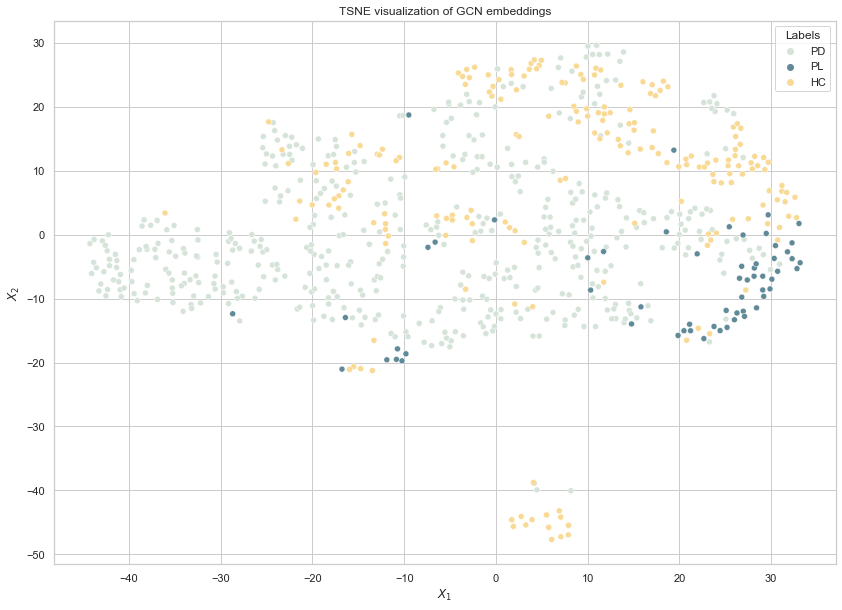

In [50]:
tsne_plot , GNN_embeddings = GNN.transform_plot(model , generator , node_subjects , pd.Series(nx.get_node_attributes(G , 'idx')).values , TSNE)